# qtcodes: an open source journey in QEC

This notebook is meant to accompany the talk given at NYUAD Hack 2022.

In [1]:
%load_ext autoreload
%autoreload 2

# Repetition Code

In [2]:
from qtcodes import RepetitionQubit, RepetitionDecoder, RotatedDecoder
from qiskit import execute, Aer, QuantumCircuit, QuantumRegister

In [3]:
qubit = RepetitionQubit({"d":3},"t")
qubit.stabilize()
qubit.circ.x(0)
qubit.stabilize()
qubit.readout_z()

results = execute(qubit.circ, Aer.get_backend('qasm_simulator'), shots=1).result().get_counts()
readout_string = list(results.keys())[0]
print("Readout String: ", readout_string)
logical_readout, syndromes = qubit.parse_readout(readout_string, "Z")
print("Logical Readout: ", logical_readout)
print("Syndromes: \n", syndromes)

Readout String:  1 01 00
Logical Readout:  1
Syndromes: 
 {'X': [], 'Z': [(0.0, 0.5, 0.5)]}


(<Figure size 440.908x293.939 with 1 Axes>, <AxesSubplot:>)

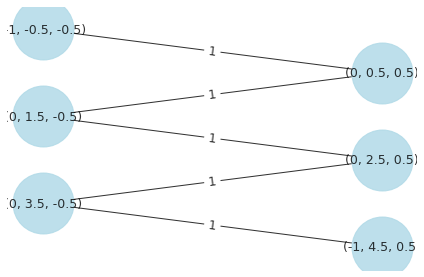

In [4]:
decoder = RepetitionDecoder({"d":5,"T":1})
G = decoder.S['Z']
decoder.draw(G)

### Look up table Decoding

In [5]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit import execute, Aer

def get_noise_model(p_err):

    error_gate1 = pauli_error([("X", p_err / 2), ("Z", p_err / 2), ("I", 1 - p_err)])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_gate1, "id")
    return noise_model

p_err = 0.10
shots = 10000


def get_results(circ):
    results = execute(circ, 
                      Aer.get_backend("aer_simulator"), 
                      noise_model=get_noise_model(p_err),
                      optimization_level=0,
                      shots=shots,
                     ).result().get_counts()
    return results

d = 3
T = 1

decoder = RotatedDecoder({"d":d,"T":T})

qubit = RepetitionQubit({'d':d})
qubit.reset_z()
qubit.stabilize()
qubit.id_data()
qubit.stabilize()
qubit.readout_z()
decoder.set_look_up_table("Z",0,get_results(qubit.circ))

qubit = RepetitionQubit({'d':d})
qubit.reset_z()
qubit.x()
qubit.stabilize()
qubit.id_data()
qubit.stabilize()
qubit.readout_z()
decoder.set_look_up_table("Z",1,get_results(qubit.circ))

The readout strings for this experiment have the following form:

$$R_{Z}\ \ \ \ \underbrace{S_2S_1}_{\text{round 2}}\ \ \ \ \underbrace{S_2S_1}_{\text{round 1}}$$

where $R_Z$ is the final logical Z readout value, and $S_1 = Z_1Z_2$ and $S_2 = Z_2Z_3$. 

In [6]:
decoder.look_up_table

{'X': {0: {}, 1: {}},
 'Z': {0: {'1 10 00': 26,
   '1 11 00': 19,
   '0 10 00': 458,
   '0 11 00': 464,
   '0 01 00': 23,
   '1 01 00': 486,
   '1 00 00': 3,
   '0 00 00': 8521},
  1: {'1 01 00': 25,
   '0 10 00': 24,
   '0 11 00': 22,
   '1 11 00': 471,
   '0 01 00': 443,
   '1 10 00': 445,
   '1 00 00': 8570}}}

In [7]:
readout_string = "1 01 00" # This corresponds to an X1 flip between stabilization rounds.
readout_type = "Z" # Logical Z readout uses Z1
print(decoder._run_look_up(readout_string, readout_type))
decoder.correct_readout_look_up_table(readout_string, readout_type)

[0.9510763209393346, 0.048923679060665366]


0

# Surface Code

X Syndrome Graph to correct X Flips
Error Graph
Matched Graph
Matches: [((0, 1.5, 0.5), (0, 0.5, 1.5))]

===

Z Syndrome Graph to correct Z Flips
Error Graph
Matched Graph
Matches: [((0, 0.5, 0.5), (0, 1.5, 1.5)), ((0, 1.5, 3.5), (0, 3.5, 3.5))]

===



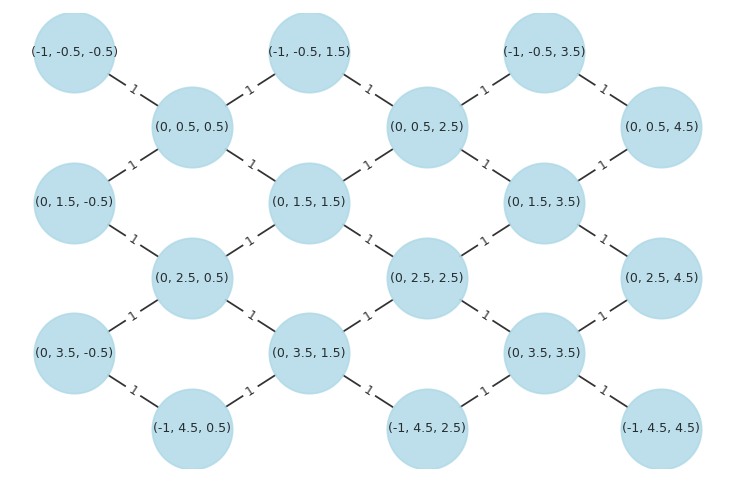

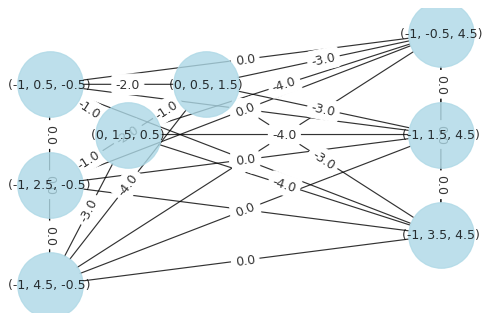

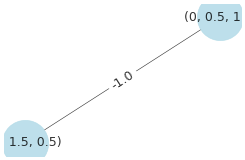

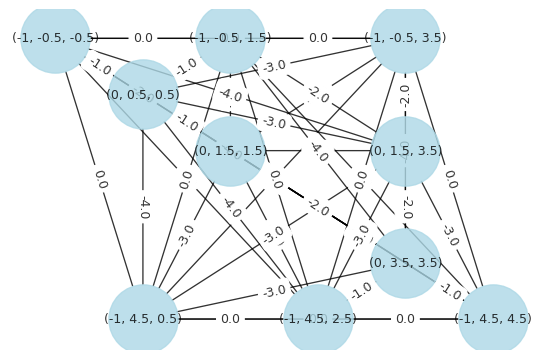

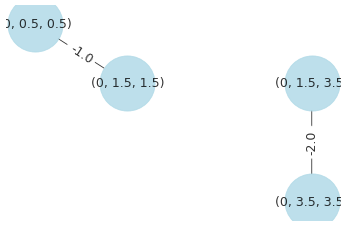

In [8]:
from qtcodes import RotatedDecoder
decoder = RotatedDecoder({"d":5,"T":1})
G = decoder.S['Z']
decoder.draw(G)

all_syndromes = {"X": [(0,1.5,.5),(0,.5,1.5)], "Z": [(0,0.5,0.5),(0,1.5,1.5),(0,1.5,3.5), (0,3.5,3.5)]}
matches = {}

for syndrome_key, syndromes in all_syndromes.items():
    print(f"{syndrome_key} Syndrome Graph to correct {syndrome_key} Flips")
    error_graph = decoder._make_error_graph(syndromes,syndrome_key)
    print("Error Graph")
    decoder.draw(error_graph)
    matches[syndrome_key] = decoder._run_mwpm(error_graph)
    matched_graph = decoder._run_mwpm_graph(error_graph)
    print("Matched Graph")
    decoder.draw(matched_graph)
    print(f"Matches: {matches[syndrome_key]}")
    print("\n===\n")

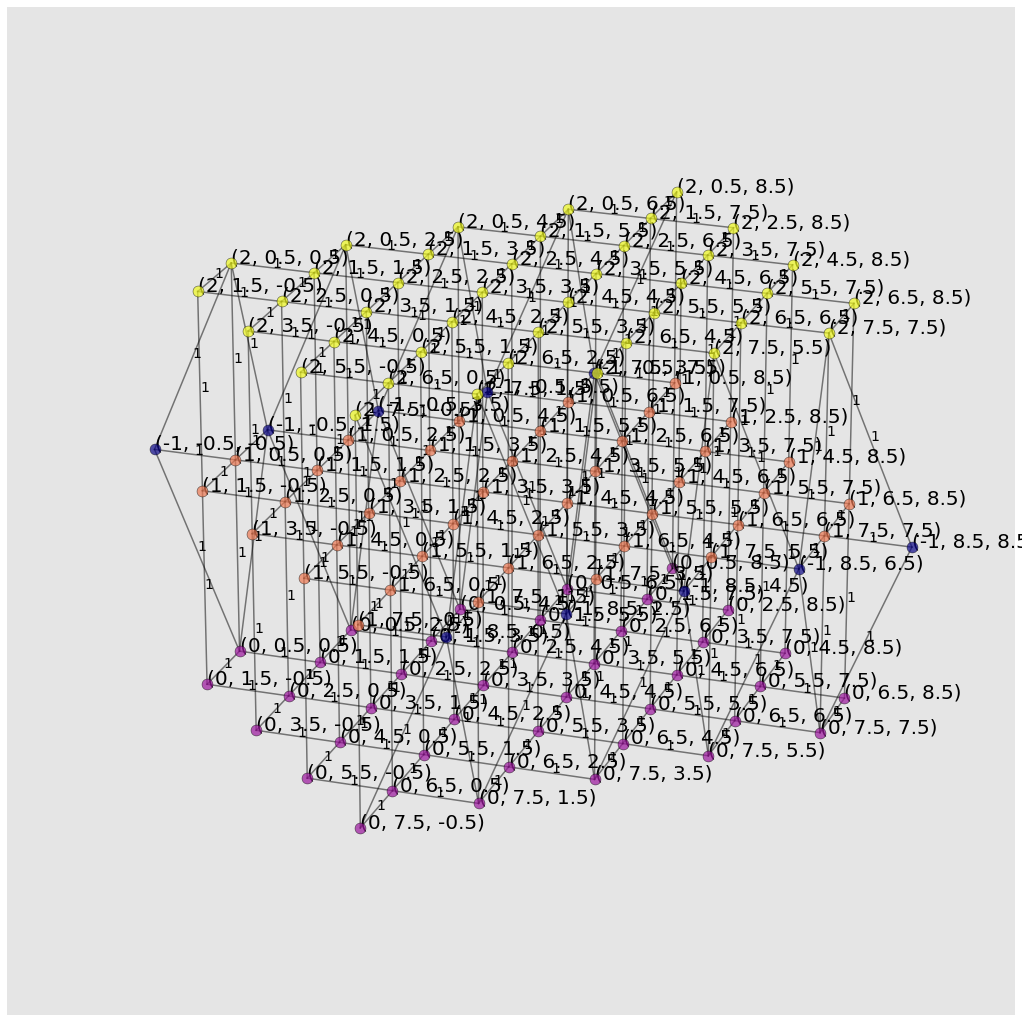

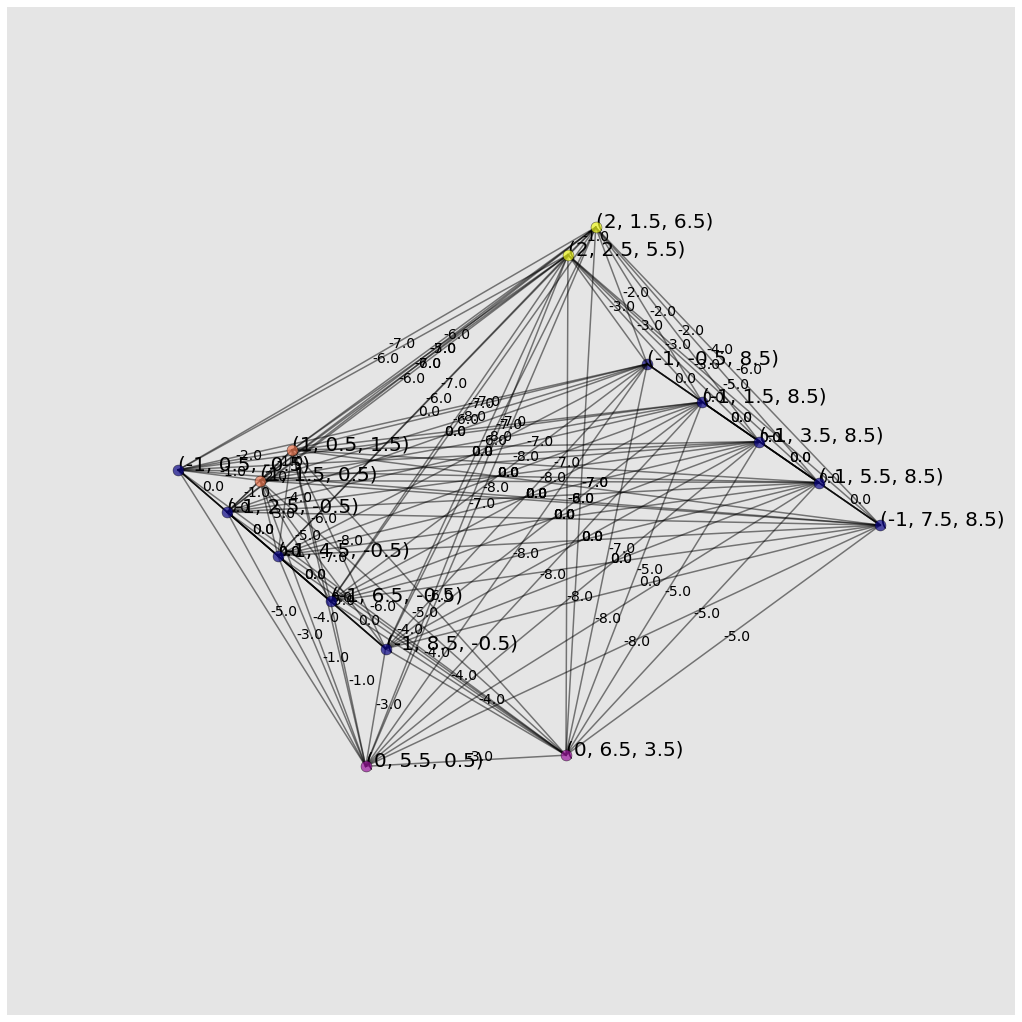

((0, 6.5, 3.5), (0, 5.5, 0.5))
((1, 0.5, 1.5), (1, 1.5, 0.5))
((2, 2.5, 5.5), (2, 1.5, 6.5))
Matched Graph


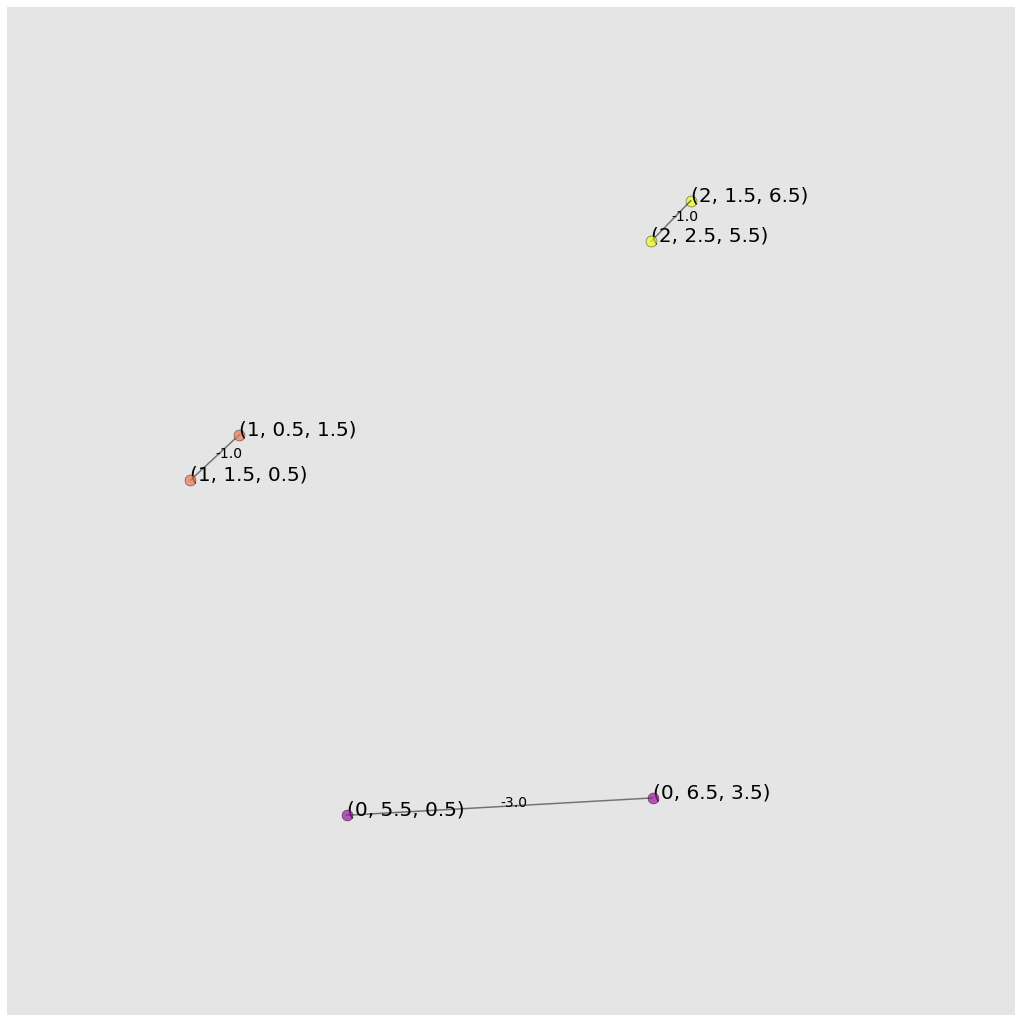

In [9]:
decoder = RotatedDecoder({"d":9,"T":3})
G = decoder.S['Z']
decoder.draw(G)

node_set = [(1,1.5,0.5),(1,0.5,1.5),(2,1.5,6.5),(2,2.5,5.5),(0,5.5,.5),(0,6.5,3.5)]
error_graph = decoder._make_error_graph(node_set,'X')
decoder.draw(error_graph)

g = decoder._run_mwpm(error_graph)
for e in g:
    print(e)
    
matches = decoder._run_mwpm(error_graph)
matched_graph = decoder._run_mwpm_graph(error_graph)
print("Matched Graph")
decoder.draw(matched_graph)

# Topological Circuit

In [10]:
from qtcodes import TopologicalRegister, TopologicalCircuit, REPETITION, XXZZ, XZZX
from qiskit import execute, Aer, QuantumCircuit, QuantumRegister

In [11]:
def sim(circ):
    return execute(circ, 
                  Aer.get_backend("aer_simulator"), 
                  shots=10,
                 ).result().get_counts()

In [12]:
treg = TopologicalRegister(ctypes=[REPETITION, XZZX], 
                           params=[{"d": 3}, {"d":3}])
tcirc = TopologicalCircuit(treg)

# prep state
tcirc.reset_z(0)
tcirc.reset_z(1)
tcirc.x(0) # logical X gate on rep qubit
tcirc.x(1) # logical X gate on XZZX qubit

# cnot
tcirc.cx(0,1)

# meas
tcirc.measure_z(0)
tcirc.measure_z(1)
# tcirc.draw(output="mpl", fold=1000)

results = sim(tcirc.circ)
results = list(set([result[:3] for result in results.keys()]))[0].split(" ")
print("original \t=> q0: 1, q1: 1")
print(f"after cnot(0,1)\t=> q0: {results[1]}, q1:{results[0]}")

original 	=> q0: 1, q1: 1
after cnot(0,1)	=> q0: 1, q1:0
